In [1]:
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import math
# from haversine import haversine
# import ipfn
# import networkx
import matplotlib.pyplot as plt
from matplotlib import patheffects
%matplotlib inline  
import skmob
from skmob.measures.evaluation import r_squared,rmse, pearson_correlation,common_part_of_commuters,max_error,common_part_of_commuters_distance
# import shapefile as shp

In [2]:
nodes = pd.read_csv('THE_NODES.txt',sep =" ",  header = None)
nodes = nodes.rename(columns = {0:'county_ID', 1:'population',2: 'latitude', 3: 'longitude', 4: 'intra_county_trips'} )
nodes.head(3)

county_ID  population   latitude  longitude  intra_county_trips
0       1001       43671  32.523283 -86.577176                7871
1       1003      140415  30.592781 -87.748260               45208
2       1005       29038  31.856515 -85.331312                8370

In [3]:
nodes_gdf = gpd.GeoDataFrame(nodes,geometry=gpd.points_from_xy(nodes.longitude,nodes.latitude))
tessellation  = nodes_gdf[['county_ID','population','geometry']]
tessellation 

county_ID  population                     geometry
0          1001       43671   POINT (-86.57718 32.52328)
1          1003      140415   POINT (-87.74826 30.59278)
2          1005       29038   POINT (-85.33131 31.85652)
3          1007       20826   POINT (-87.12324 33.04005)
4          1009       51024   POINT (-86.55477 33.97846)
...         ...         ...                          ...
3136      56037       37613  POINT (-109.16820 41.64071)
3137      56039       18251  POINT (-110.67353 43.61212)
3138      56041       19742  POINT (-110.59988 41.28392)
3139      56043        8289  POINT (-107.72897 43.96022)
3140      56045        6644  POINT (-104.56240 43.87979)

[3141 rows x 3 columns]

In [4]:
links = pd.read_csv('THE_LINKS.txt',sep =" ",  header = None)
links = links.rename(columns = {0:'origin_county', 1:'destination_county',2: 'distance_[km]', 3: 'number_of_trips.'} )
links.head(3)

origin_county  destination_county  distance_[km]  number_of_trips.
0           1001                1001       0.000000              7871
1           1001                1007      76.861597                 7
2           1001                1013      87.918287                37

In [5]:
link_ = pd.read_csv('THE_LINKS.txt',sep =" ",  header = None)
link_ = link_.rename(columns = {0:'origin', 1:'destination',2: 'distance_[km]', 3: 'flow'} )
link_ = link_[['origin','destination','flow']]
link_.head(3)

origin  destination  flow
0    1001         1001  7871
1    1001         1007     7
2    1001         1013    37

In [6]:
fdf = skmob.FlowDataFrame(
    data = links, origin = 'origin_county' , destination = 'destination_county', flow = 'number_of_trips.' ,
    tessellation=tessellation, tile_id='county_ID');

C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\scikit_mobility-1.0-py3.7.egg\skmob\core\flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).


In [7]:
fdf.head()

origin destination  distance_[km]  flow
0   1001        1001       0.000000  7871
1   1001        1007      76.861597     7
2   1001        1013      87.918287    37
3   1001        1015     152.858742     5
4   1001        1021      38.103967   350

In [8]:
fdf.dtypes

origin            object
destination       object
distance_[km]    float64
flow               int64
dtype: object

In [9]:
# The tessellation is an attribute of the FlowDataFrame
fdf.tessellation.head() 

tile_ID  population                    geometry
0    1001       43671  POINT (-86.57718 32.52328)
1    1003      140415  POINT (-87.74826 30.59278)
2    1005       29038  POINT (-85.33131 31.85652)
3    1007       20826  POINT (-87.12324 33.04005)
4    1009       51024  POINT (-86.55477 33.97846)

In [10]:
fdf.tessellation.tile_ID.nunique()

3141

In [11]:
## plot tesselation
fdf.plot_tessellation(popup_features=['tile_ID', 'population']) 

In [12]:
## plot tesselation and flows
map_f = fdf.plot_tessellation(style_func_args={'color':'blue', 'fillColor':'blue'})
fdf[fdf['origin'] == '36061'].plot_flows(map_f=map_f, flow_exp=0.0, flow_popup=True)

### 1. Read the data and report total out-flows and in-flows of the entire data set

In [13]:
## total outflows
outflows = links.groupby(['origin_county']).sum()['number_of_trips.'].values - nodes['intra_county_trips'].values
total_outflow = sum(outflows)
print('total outflows: ', total_outflow)

total outflows:  34116820


In [14]:
## total inflows
inflows = links.groupby(['destination_county']).sum()['number_of_trips.'].values - nodes['intra_county_trips'].values
print('total inflows: ', sum(inflows))

total inflows:  34116820


### 2. What is the population in the set of counties (P)

In [15]:
## Total populations
P = np.sum(nodes.population)
print('Total population in set of counties: ', P)

Total population in set of counties:  281421906


### 3. What is the ratio between total out-flows and (P), why is not close to 1?

In [16]:
## Ratio between total outflows and P
ratio_o_P = total_outflow/P
print('Ratio between total outflows and P : ',ratio_o_P)

Ratio between total outflows and P :  0.1212301504347


The ration between the total outflows and P is not equals to 1 because the intra country flows has not been accounted for. we can notice from the data that the intracounty flows account for a huge amount of the total number of trips i.e most of the population movement is happening within the county. As such the ratio of outflows to total population is much less than 1( order of 0.1) because the intracounty flows are removed and we do not account for the people moving within the county.

### Models

In [17]:
from skmob.utils import utils, constants
from skmob.models import Gravity


### Compute the total outflows from each location of the tessellation (excluding self loops)

In [18]:
tot_outflows = fdf[fdf['origin'] != fdf['destination']].groupby(by='origin', axis=0)['flow'].sum().fillna(0).values
len(fdf.tessellation)
len(tot_outflows )

3140

In [19]:
## find index and position of missing id
a = fdf['origin'].unique()
b = fdf[fdf['origin'] != fdf['destination']]['origin'].unique()
for ii, id_ in enumerate(a):
    if id_ not in b:
        print('index: ', ii, 'id value: ', id_)

index:  545 id value:  15005


In [20]:
## insert outflow of zero to missing index:  545  with id value:  15005
tot_outflows = np.insert(tot_outflows, 545,0)

In [21]:
len(tot_outflows)

3141

In [22]:
# print(fdf.shape)
# print(fdf['origin'].unique())
# print(fdf[fdf['origin'] != fdf['destination']].shape)
# print(fdf[fdf['origin'] != fdf['destination']]['origin'].unique())
# fdf[fdf['origin'] != fdf['destination']].groupby(by='origin', axis=0).sum().shape


In [23]:
tessellation[constants.TOT_OUTFLOW] = tot_outflows
print(tessellation.head())

   county_ID  population                    geometry  tot_outflow
0       1001       43671  POINT (-86.57718 32.52328)        12293
1       1003      140415  POINT (-87.74826 30.59278)        35275
2       1005       29038  POINT (-85.33131 31.85652)        16045
3       1007       20826  POINT (-87.12324 33.04005)        11921
4       1009       51024  POINT (-86.55477 33.97846)        16977


C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [24]:
## check if values properly inserted
tessellation[tessellation['county_ID']== 15005]

county_ID  population                     geometry  tot_outflow
545      15005         147  POINT (-156.97098 21.18846)            0

In [25]:
np.sum(tot_outflows)

34116820

### 4. Singly Constrained GM: Fit the data with an out-flow singly constrained gravity model with exponential decaying function. Report the parameters of the model and show the scatter plot of data vs model

In [26]:
## creating instance of singly constrained model
gravity_singly = Gravity(gravity_type='singly constrained')
print(gravity_singly)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [27]:
sin_con_fdf = gravity_singly.generate(tessellation,
                                   tile_id_column='county_ID',
                                   tot_outflows_column='tot_outflow',
                                   relevance_column= 'population',
                                   out_format='flows')

100%|██████████████████████████████████████████████████████████████████████████████| 3141/3141 [00:31<00:00, 99.86it/s]
C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\scikit_mobility-1.0-py3.7.egg\skmob\models\gravity.py:43: RuntimeWarning: divide by zero encountered in power
C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\scikit_mobility-1.0-py3.7.egg\skmob\core\flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).


In [28]:
sin_con_fdf.head()

origin destination  flow
0   1001        1003    29
1   1001        1005    18
2   1001        1007    39
3   1001        1009    18
4   1001        1011    13

In [29]:
## Visual evaluation
# ny_base_map=fdf.plot_flows(min_flow=100, tiles='cartodbpositron', flow_weight=2, opacity=0.25)
# sin_con_fdf.plot_flows(map_f=ny_base_map, min_flow=100, tiles='cartodbpositron', flow_weight=2, opacity=0.05, flow_color='black')

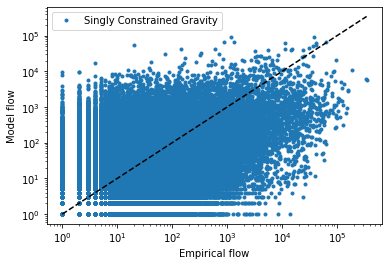

In [30]:
## Comparing empirical flows against model
xy = fdf.merge(sin_con_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
## create plot
plt.plot(xy[:,0], xy[:,1], '.', label='Singly Constrained Gravity')
x = np.logspace(0, np.log10(np.max(xy)))
plt.plot(x, x, '--k')
plt.xlabel('Empirical flow'); plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog(); plt.show()

In [31]:
## Quantitative evaluation metrics
metrics = [r_squared, rmse, pearson_correlation,common_part_of_commuters,
           max_error,common_part_of_commuters_distance]
names = ['r_squared', 'rmse', 'pearson_correlation','common_part_of_commuters',
         'max_error','common_part_of_commuters_distance']
print('Metric:Gravity Doubly Constrained')
print('---------------------------')
for i, metric in enumerate(metrics):
    m = metric(xy[:, 0], xy[:, 1])
    print("%s:   %s " % (names[i], np.round(m,5)))

Metric:Gravity Doubly Constrained
---------------------------
r_squared:   0.01193 
rmse:   2987.20186 
pearson_correlation:   [0.17906 0.     ] 
common_part_of_commuters:   0.36636 
max_error:   340598 
common_part_of_commuters_distance:   0.00296 


### 5. Doubly Constrained GM: Fit the data with an doubly constrained gravity model with exponential decaying function. Report the parameters of the model and show the scatter plot of data vs model + Evaluation metrics

In [32]:
## create doubly constrained model
gravity_doubly = Gravity(gravity_type='globally constrained', deterrence_func_type='exponential',deterrence_func_args=[0.012],origin_exp=0.46, destination_exp=0.64)
print(gravity_doubly)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[0.012], origin_exp=0.46, destination_exp=0.64, gravity_type="globally constrained")


In [33]:
## create instance of daoubly constrained model
dob_con_fdf = gravity_doubly.generate(tessellation,
                                   tile_id_column='county_ID',
                                   tot_outflows_column='tot_outflow',
                                   relevance_column= 'population',
                                   out_format='flows')

100%|██████████████████████████████████████████████████████████████████████████████| 3141/3141 [00:32<00:00, 95.77it/s]
C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\scikit_mobility-1.0-py3.7.egg\skmob\core\flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).


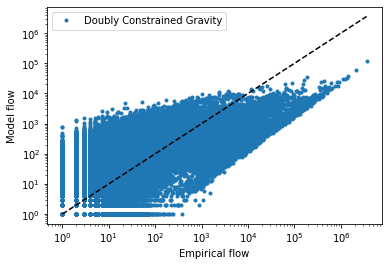

In [34]:
## Comparing empirical flows against model
xy_ = fdf.merge(dob_con_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
# xy_
# create plot
plt.plot(xy_[:,0], xy_[:,1], '.', label='Doubly Constrained Gravity')
x = np.logspace(0, np.log10(np.max(xy_)))
plt.plot(x, x, '--k')
plt.xlabel('Empirical flow'); plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog(); plt.show()

In [41]:
## Quantitative evaluation metrics
metrics = [r_squared, rmse, pearson_correlation,common_part_of_commuters,
           max_error,common_part_of_commuters_distance]
names = ['r_squared', 'rmse', 'pearson_correlation','common_part_of_commuters',
         'max_error','common_part_of_commuters_distance']
print('Metric:Gravity Doubly Constrained')
print('---------------------------')
for i, metric in enumerate(metrics):
    m = metric(xy_[:, 0], xy_[:, 1])
    print("%s:   %s " % (names[i], np.round(m,5)))

Metric:Gravity Doubly Constrained
---------------------------
r_squared:   0.05722 
rmse:   17877.7238 
pearson_correlation:   [0.76537 0.     ] 
common_part_of_commuters:   0.53271 
max_error:   3460067 
common_part_of_commuters_distance:   0.00055 


### 6. Radiation Model: Fit the data with the Radiation model. Show the scatter plot of data vs mode

In [36]:
from skmob.models import Radiation
## generate radiation model
radiation = Radiation()
## create instance of radiation model
rad_flows = radiation.generate(tessellation, tile_id_column='county_ID', tot_outflows_column='tot_outflow',
                                   relevance_column='population', out_format='flows_sample')


100%|██████████████████████████████████████████████████████████████████████████████| 3141/3141 [02:57<00:00, 17.72it/s]
C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\scikit_mobility-1.0-py3.7.egg\skmob\core\flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).


In [37]:
## model parameters
print(radiation)

In [38]:
xy

array([[ 7, 39],
       [37, 31],
       [ 5, 67],
       ...,
       [11, 40],
       [ 8, 34],
       [ 5, 75]], dtype=int64)

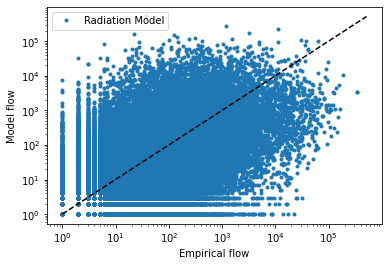

In [39]:
## Comparing empirical flows against model
xy_2 = fdf.merge(rad_flows, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
## create plot
plt.plot(xy_2[:,0], xy_2[:,1], '.', label='Radiation Model')
x = np.logspace(0, np.log10(np.max(xy_2)))
plt.plot(x, x, '--k')
plt.xlabel('Empirical flow'); plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog(); plt.show()

In [40]:
## Quantitative evaluation metrics
metrics = [r_squared, rmse, pearson_correlation,common_part_of_commuters,
           max_error,common_part_of_commuters_distance]
names = ['r_squared', 'rmse', 'pearson_correlation','common_part_of_commuters',
         'max_error','common_part_of_commuters_distance']
print('Metric:Radiation model')
print('---------------------------')
for i, metric in enumerate(metrics):
    m = metric(xy_2[:, 0], xy_2[:, 1])
    print("%s:   %s " % (names[i], np.round(m,5)))

Metric:Radiation model
---------------------------
r_squared:   -0.99903 
rmse:   5212.86754 
pearson_correlation:   [0.06676 0.     ] 
common_part_of_commuters:   0.21103 
max_error:   342932 
common_part_of_commuters_distance:   0.00179 
